In [19]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Directorio donde se encuentran las imágenes
data_dir = "faces"

# Función para cargar imágenes y etiquetas
def load_data(data_dir):
    images = []
    labels = []
    
    for person in os.listdir(data_dir):
        person_path = os.path.join(data_dir, person)
        
        for file in os.listdir(person_path):
            if file.endswith(".pgm") and not file.endswith(".bad"):
                file_path = os.path.join(person_path, file)
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (64, 60))  # Redimensionar a media resolución
                images.append(img)
                labels.append("glasses" if "sunglasses" in file else "no_glasses")
                
    return np.array(images), np.array(labels)

# Cargar datos
images, labels = load_data(data_dir)

# Codificar etiquetas
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
encoded_labels = to_categorical(encoded_labels)


# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Aplicar aumento de datos
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Expandir las dimensiones de las imágenes
X_train_expanded = np.expand_dims(X_train, axis=-1)
X_test_expanded = np.expand_dims(X_test, axis=-1)

datagen.fit(X_train_expanded)

# Construir el modelo
model = keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(60, 64, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.7),
    layers.Dense(2, activation='softmax')
])

# Cambiar el optimizador y la tasa de aprendizaje
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con aumento de datos
model.fit(datagen.flow(X_train_expanded, y_train, batch_size=64), epochs=100, validation_data=(X_test_expanded, y_test))

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(X_test_expanded, y_test)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/100
24/24 [==============================] - 4s 161ms/step - loss: 4.8850 - accuracy: 0.5023 - val_loss: 0.7058 - val_accuracy: 0.5173
Epoch 2/100
24/24 [==============================] - 4s 152ms/step - loss: 0.7967 - accuracy: 0.5257 - val_loss: 0.6888 - val_accuracy: 0.5733
Epoch 3/100
24/24 [==============================] - 4s 159ms/step - loss: 0.6966 - accuracy: 0.5050 - val_loss: 0.6913 - val_accuracy: 0.5440
Epoch 4/100
24/24 [==============================] - 4s 153ms/step - loss: 0.6894 - accuracy: 0.5297 - val_loss: 0.6852 - val_accuracy: 0.6027
Epoch 5/100
24/24 [==============================] - 4s 160ms/step - loss: 0.6886 - accuracy: 0.5377 - val_loss: 0.6867 - val_accuracy: 0.6000
Epoch 6/100
24/24 [==============================] - 4s 151ms/step - loss: 0.6894 - accuracy: 0.5284 - val_loss: 0.6843 - val_accuracy: 0.5840
Epoch 7/100
24/24 [==============================] - 4s 156ms/step - loss: 0.6832 - accuracy: 0.5605 - val_loss: 0.6643 - val_accuracy: 0.6373

12/12 [==============================] - 0s 15ms/step


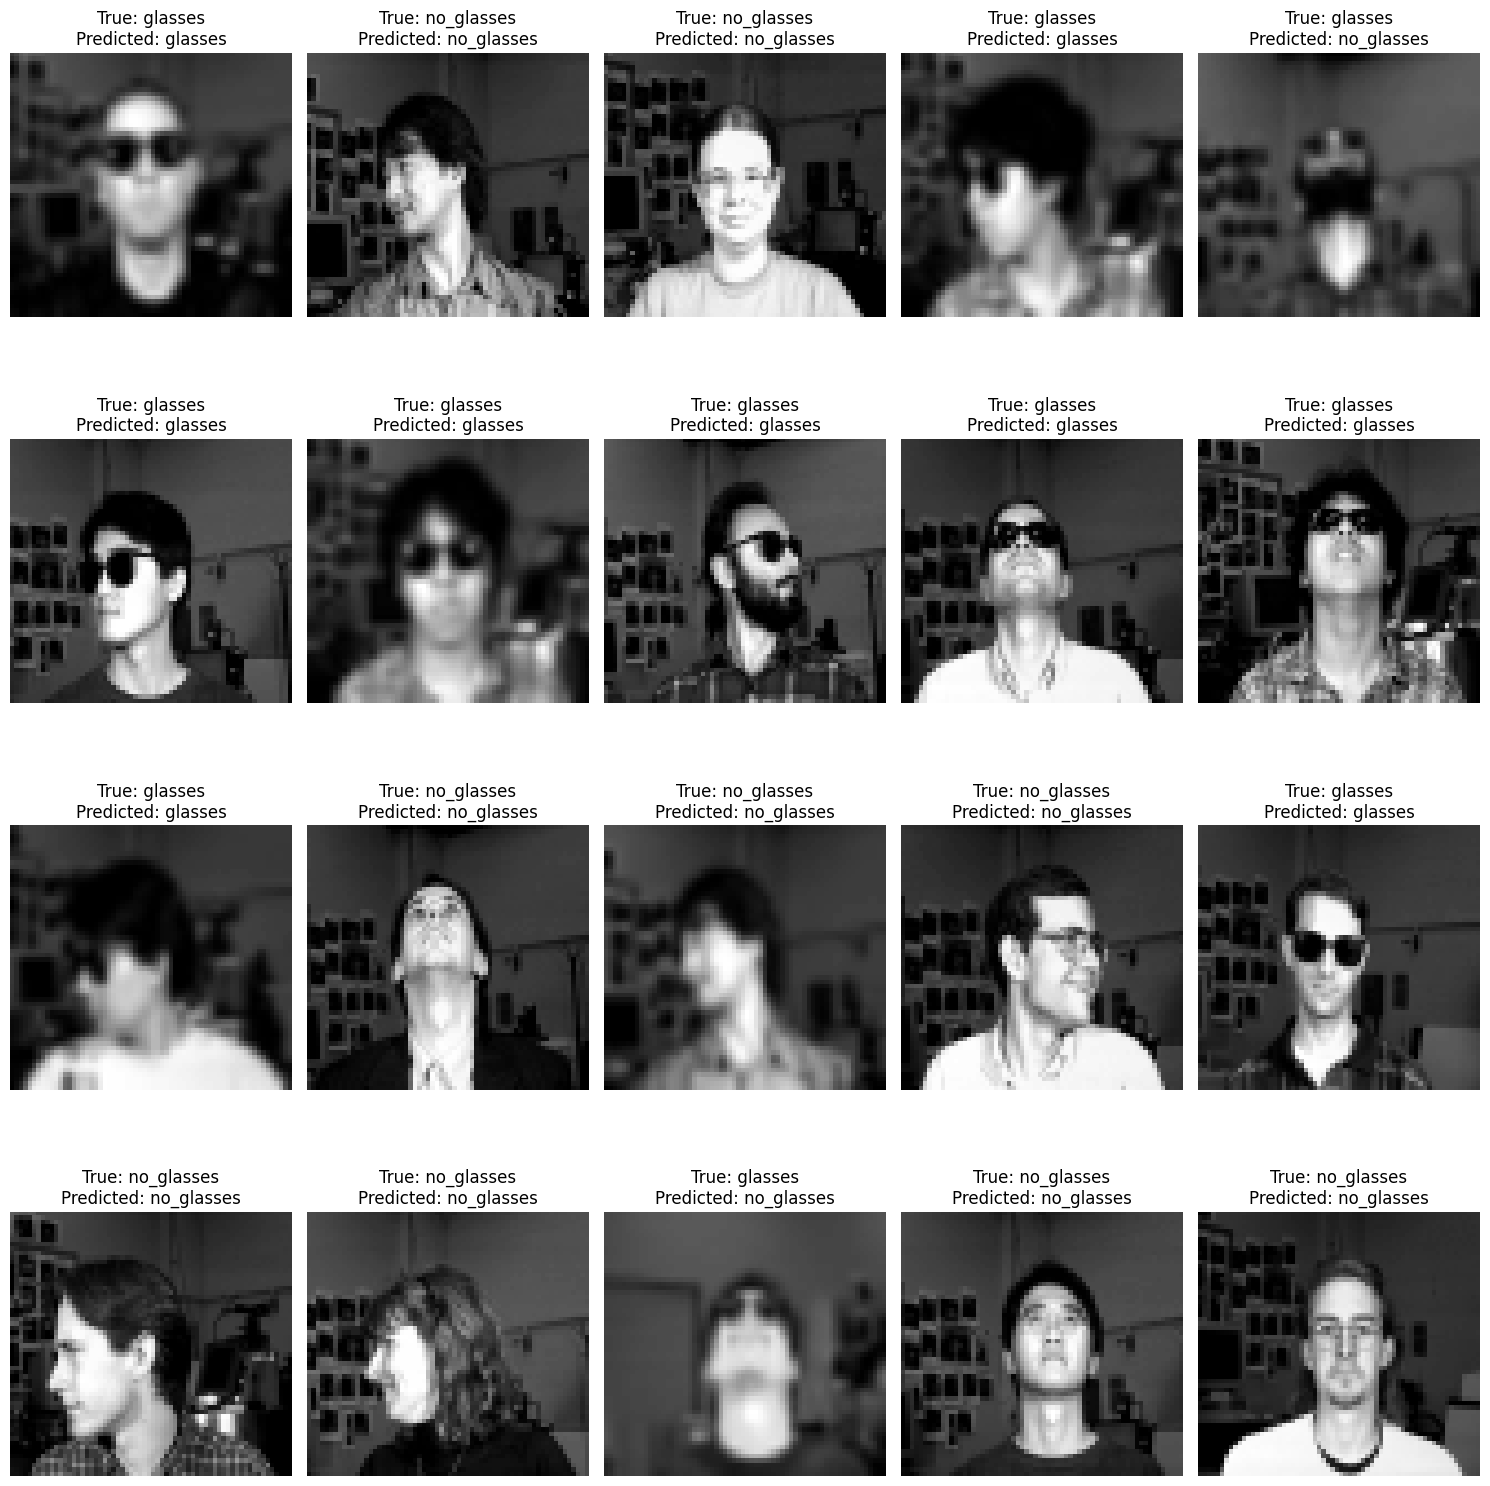

In [23]:
# Función para mostrar imágenes con sus predicciones
def show_predictions(model, X_data, y_data, label_encoder, num_samples=20):
    predictions = model.predict(X_data)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_data, axis=1)
    class_names = label_encoder.classes_

    num_rows = (num_samples // 5) + (num_samples % 5 > 0)
    plt.figure(figsize=(15, num_rows * 4))

    for i in range(num_samples):
        plt.subplot(num_rows, 5, i + 1)
        plt.imshow(X_data[i, :, :, 0], cmap='gray')
        plt.title(f'True: {class_names[true_classes[i]]}\nPredicted: {class_names[predicted_classes[i]]}', fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar predicciones en el conjunto de prueba
show_predictions(model, X_test_expanded, y_test, label_encoder, num_samples=20)


12/12 [==============================] - 0s 15ms/step


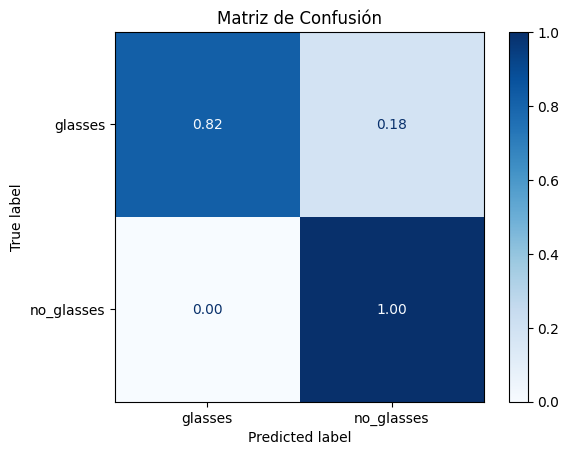

In [21]:
# Obtener predicciones y clases verdaderas
predictions = model.predict(X_test_expanded)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes, normalize='true')

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='.2f')
plt.title('Matriz de Confusión')
plt.show()


In [31]:
# Ruta a la carpeta que contiene las nuevas imágenes
new_images_path = "prueba"

# Función para cargar y preprocesar nuevas imágenes
def load_new_images(folder_path):
    images = []
    file_names = []
    
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 60))  # Redimensionar a media resolución
        images.append(img)
        file_names.append(file)
        
    return np.array(images), file_names

# Cargar nuevas imágenes
new_images, new_image_names = load_new_images(new_images_path)

# Expandir las dimensiones de las imágenes
new_images_expanded = np.expand_dims(new_images, axis=-1)

# Realizar predicciones con el modelo
predictions = model.predict(new_images_expanded)
predicted_classes = np.argmax(predictions, axis=1)

# Decodificar las clases predichas
decoded_classes = label_encoder.inverse_transform(predicted_classes)

# Mostrar los resultados
for i in range(len(new_image_names)):
    print(f"Imagen: {new_image_names[i]}, Predicción: {decoded_classes[i]}")


1/1 [==============================] - 0s 27ms/step
Imagen: sun-glasses2.jpg, Predicción: glasses
Imagen: without-glasses3.jpg, Predicción: no_glasses
Imagen: sun-glasses5.jpeg, Predicción: glasses
Imagen: without-glasses2.jpg, Predicción: no_glasses
Imagen: without-glasses4.jpg, Predicción: no_glasses
Imagen: without-glasses5.jpg, Predicción: no_glasses
Imagen: sun-glasses3.jpg, Predicción: glasses
Imagen: sun-glasses.jpg, Predicción: glasses
Imagen: sun-glasses4.jpeg, Predicción: glasses
Imagen: without-glasses1.jpg, Predicción: no_glasses


1/1 [==============================] - 0s 24ms/step


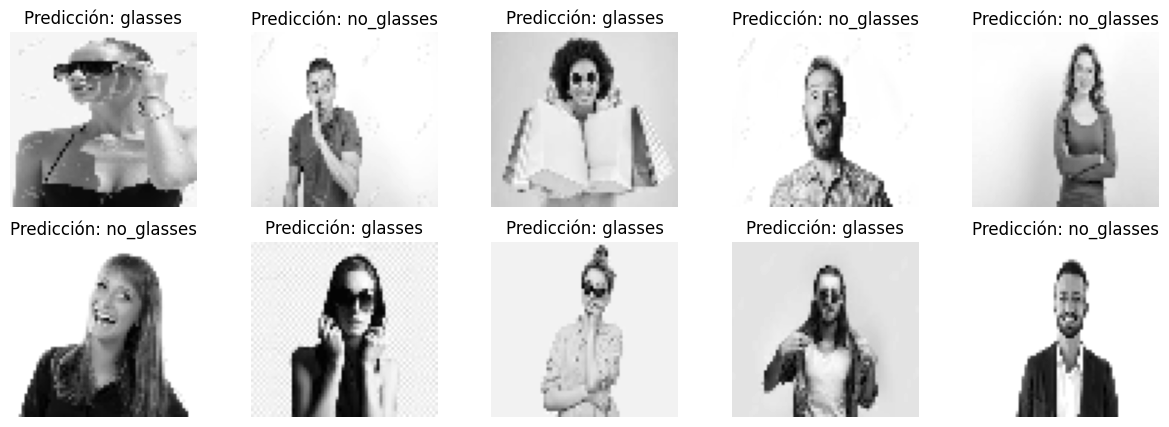

In [29]:
# Ruta a la carpeta que contiene las nuevas imágenes
new_images_path = "pruebaImagenesExternasDataSet"

# Función para cargar y preprocesar nuevas imágenes
def load_new_images(folder_path):
    images = []
    file_names = []
    
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 60))  # Redimensionar a media resolución
        images.append(img)
        file_names.append(file)
        
    return np.array(images), file_names

# Cargar nuevas imágenes
new_images, new_image_names = load_new_images(new_images_path)

# Expandir las dimensiones de las imágenes
new_images_expanded = np.expand_dims(new_images, axis=-1)

# Realizar predicciones con el modelo
predictions = model.predict(new_images_expanded)
predicted_classes = np.argmax(predictions, axis=1)

# Decodificar las clases predichas
decoded_classes = label_encoder.inverse_transform(predicted_classes)

# Mostrar los resultados
plt.figure(figsize=(15, 5))
for i in range(len(new_image_names)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(new_images[i], cmap='gray')
    plt.title(f'Predicción: {decoded_classes[i]}')
    plt.axis('off')

plt.show()


In [30]:
# Guardar las clases del LabelEncoder en un archivo para
np.save("label_encoder.npy", label_encoder.classes_)


In [32]:
# Ruta donde guardar el modelo
modelo_ruta = "modeloDeReconocimientoDeGafasDeSol.keras"

# Guardar el modelo
model.save(modelo_ruta)


print(f"Modelo guardado en: {modelo_ruta}")

Modelo guardado en: modeloDeReconocimientoDeGafasDeSol.keras
